In [2]:
import numpy as np 
import struct
from array import array
from os.path  import join
import random
import matplotlib.pyplot as plt


# Phần 0: Đọc dữ liệu từ file IDX

In [3]:

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

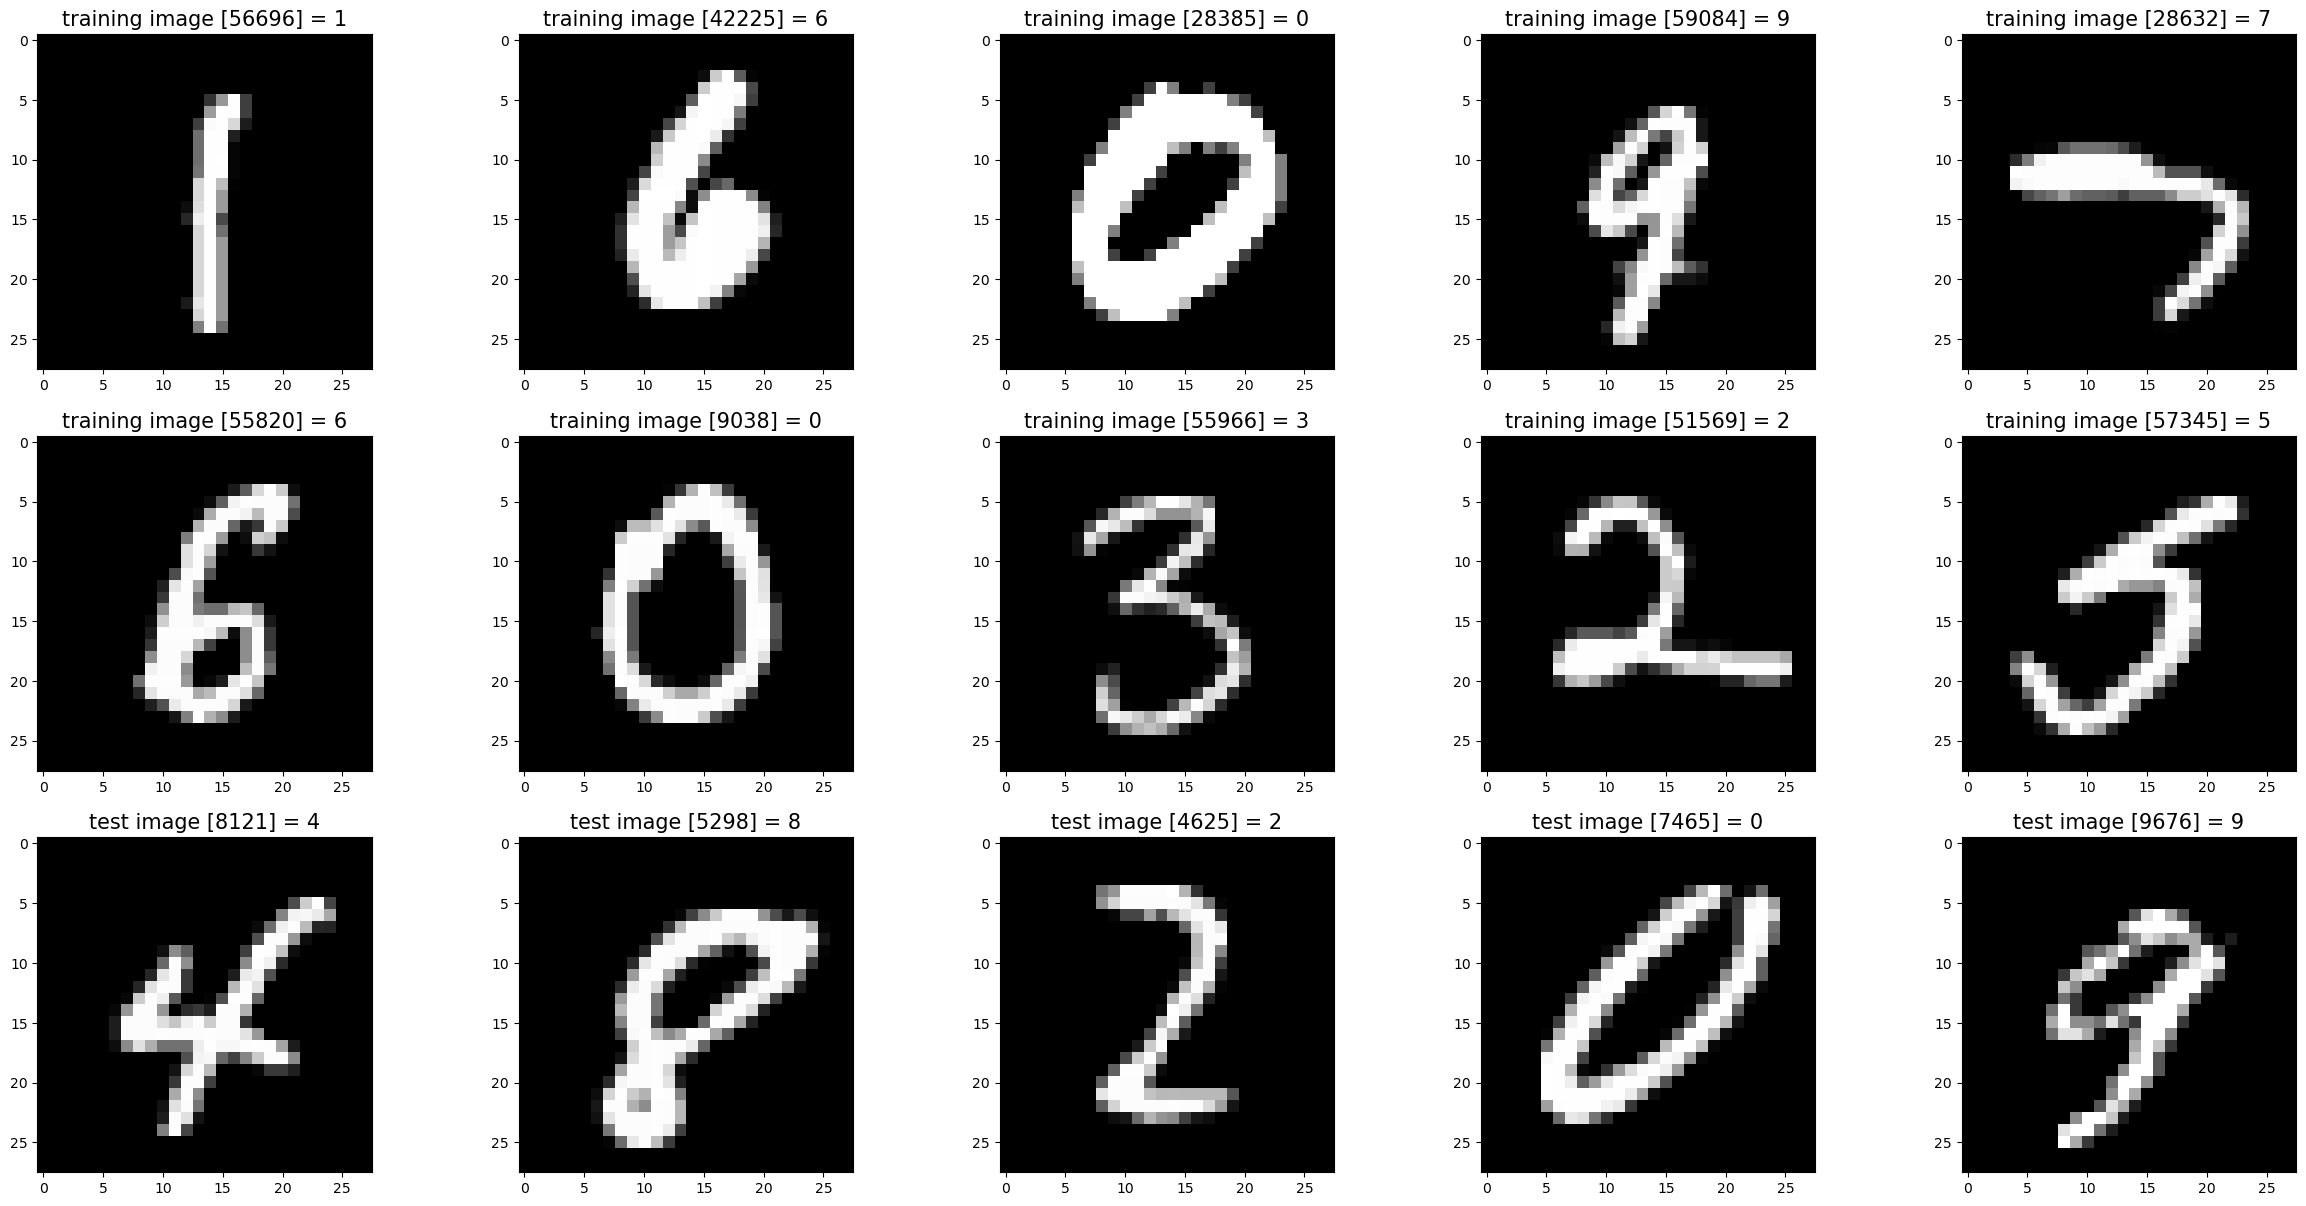

In [4]:
input_path = '../data'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# MNIST Classification với Softmax Regression

## Mục tiêu
Xây dựng mô hình Softmax Regression từ đầu chỉ sử dụng NumPy, so sánh 3 loại feature engineering:
1. **Raw Pixel Features** - Pixel chuẩn hóa
2. **Edge Features** - Đặc trưng biên cạnh (Sobel/Canny)
3. **Dimensionality Reduction** - PCA hoặc Block Averaging

---

## PHẦN 1: MATHEMATICAL FORMULATION

### 1.1 Model Hypothesis
Với input $\mathbf{x} \in \mathbb{R}^{d}$ (d chiều) và K classes (K=10 cho MNIST):

$$\mathbf{z} = \mathbf{W}^T \mathbf{x} + \mathbf{b}$$

Trong đó:
- $\mathbf{W} \in \mathbb{R}^{d \times K}$: Ma trận trọng số
- $\mathbf{b} \in \mathbb{R}^{K}$: Bias vector
- $\mathbf{z} \in \mathbb{R}^{K}$: Logits (scores chưa chuẩn hóa)

### 1.2 Softmax Function
Chuyển logits thành phân phối xác suất:

$$\hat{y}_k = \text{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

Trong đó $\hat{y}_k$ là xác suất dự đoán cho class k.

### 1.3 Cross-Entropy Loss Function
Với one-hot encoded label $\mathbf{y}$ (y_k = 1 nếu là class k, ngược lại 0):

$$L(\mathbf{W}, \mathbf{b}) = -\frac{1}{N}\sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})$$

Với regularization (L2):

$$J(\mathbf{W}, \mathbf{b}) = L(\mathbf{W}, \mathbf{b}) + \frac{\lambda}{2N} \|\mathbf{W}\|_F^2$$

### 1.4 Gradient Descent Update Rules

**Gradient của loss theo W và b:**

$$\frac{\partial L}{\partial \mathbf{z}} = \hat{\mathbf{y}} - \mathbf{y}$$

$$\frac{\partial L}{\partial \mathbf{W}} = \frac{1}{N}\mathbf{X}^T(\hat{\mathbf{Y}} - \mathbf{Y}) + \frac{\lambda}{N}\mathbf{W}$$

$$\frac{\partial L}{\partial \mathbf{b}} = \frac{1}{N}\sum_{i=1}^{N}(\hat{\mathbf{y}}_i - \mathbf{y}_i)$$

**Update rules:**

$$\mathbf{W} \leftarrow \mathbf{W} - \alpha \frac{\partial L}{\partial \mathbf{W}}$$

$$\mathbf{b} \leftarrow \mathbf{b} - \alpha \frac{\partial L}{\partial \mathbf{b}}$$

Trong đó $\alpha$ là learning rate.

In [5]:
# Import thêm thư viện cần thiết
import cv2
import seaborn as sns
from collections import defaultdict
import time

print("Dã import các thư viện cần thiết")

Dã import các thư viện cần thiết


## PHẦN 2: DATA PREPROCESSING & NORMALIZATION

In [6]:
# Chuẩn bị dữ liệu: chuyển list sang numpy array và normalize
X_train_raw = np.array(x_train, dtype=np.float32)  # Shape: (60000, 28, 28)
X_test_raw = np.array(x_test, dtype=np.float32)    # Shape: (10000, 28, 28)
y_train_raw = np.array(y_train, dtype=np.int32)
y_test_raw = np.array(y_test, dtype=np.int32)

# Normalize pixel values về [0, 1]
X_train_raw = X_train_raw / 255.0
X_test_raw = X_test_raw / 255.0

print(f"Training set: {X_train_raw.shape}")
print(f"Test set: {X_test_raw.shape}")
print(f"Labels train: {y_train_raw.shape}")
print(f"Labels test: {y_test_raw.shape}")
print(f"Pixel range: [{X_train_raw.min():.2f}, {X_train_raw.max():.2f}]")
print(f"Classes: {np.unique(y_train_raw)}")

Training set: (60000, 28, 28)
Test set: (10000, 28, 28)
Labels train: (60000,)
Labels test: (10000,)
Pixel range: [0.00, 1.00]
Classes: [0 1 2 3 4 5 6 7 8 9]


## PHẦN 3: SOFTMAX REGRESSION MODEL (NumPy Implementation)

In [7]:
class SoftmaxRegression:
    """
    Softmax Regression Model - Implementation từ đầu chỉ dùng NumPy
    """
    
    def __init__(self, n_features, n_classes=10, learning_rate=0.01, reg_lambda=0.01):
        """
        Khởi tạo model
        
        Args:
            n_features: Số chiều của feature vector
            n_classes: Số lượng classes (10 cho MNIST)
            learning_rate: Learning rate cho gradient descent
            reg_lambda: Hệ số regularization L2
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        
        # Khởi tạo weights và bias ngẫu nhiên (Xavier initialization)
        self.W = np.random.randn(n_features, n_classes) * np.sqrt(2.0 / n_features)
        self.b = np.zeros(n_classes)
        
        # Lưu lịch sử training
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []
    
    def softmax(self, z):
        """
        Softmax function với numerical stability
        
        Args:
            z: Logits, shape (N, K)
        
        Returns:
            Probabilities, shape (N, K)
        """
        # Trừ max để tránh overflow
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def compute_loss(self, X, y, W, b):
        """
        Tính Cross-Entropy Loss với L2 regularization
        
        Args:
            X: Input features, shape (N, d)
            y: True labels (integers), shape (N,)
            W: Weights
            b: Bias
        
        Returns:
            loss: Scalar loss value
        """
        N = X.shape[0]
        
        # Forward pass
        logits = X @ W + b  # (N, K)
        probs = self.softmax(logits)  # (N, K)
        
        # Cross-entropy loss
        correct_class_probs = probs[np.arange(N), y]
        loss = -np.mean(np.log(correct_class_probs + 1e-15))    
              
        # L2 regularization
        loss += (self.reg_lambda / (2 * N)) * np.sum(W * W)
        
        return loss
    
    def compute_accuracy(self, X, y):
        """Tính accuracy"""
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              epochs=100, batch_size=128, verbose=True):
        """
        Training với mini-batch gradient descent
        
        Args:
            X_train: Training features, shape (N, d)
            y_train: Training labels, shape (N,)
            X_val: Validation features (optional)
            y_val: Validation labels (optional)
            epochs: Số lượng epochs
            batch_size: Batch size
            verbose: In thông tin training
        """
        N = X_train.shape[0]
        n_batches = N // batch_size
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(N)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            epoch_loss = 0
            
            # Mini-batch gradient descent
            for i in range(n_batches):
                start_idx = i * batch_size
                end_idx = start_idx + batch_size
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Forward pass
                logits = X_batch @ self.W + self.b  # (batch_size, K)
                probs = self.softmax(logits)  # (batch_size, K)
                
                # Compute loss
                batch_loss = self.compute_loss(X_batch, y_batch, self.W, self.b)
                epoch_loss += batch_loss
                
                # Backward pass (Gradient computation)
                # dL/dz = probs - one_hot(y)
                grad_logits = probs.copy()
                grad_logits[np.arange(batch_size), y_batch] -= 1
                grad_logits /= batch_size
                
                # dL/dW = X^T @ grad_logits + regularization
                grad_W = X_batch.T @ grad_logits + (self.reg_lambda / N) * self.W
                
                # dL/db = sum(grad_logits)
                grad_b = np.sum(grad_logits, axis=0)
                
                # Update weights
                self.W -= self.learning_rate * grad_W
                self.b -= self.learning_rate * grad_b
            
            # Tính metrics sau mỗi epoch
            avg_loss = epoch_loss / n_batches
            train_acc = self.compute_accuracy(X_train, y_train)
            
            self.train_loss_history.append(avg_loss)
            self.train_acc_history.append(train_acc)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val, self.W, self.b)
                val_acc = self.compute_accuracy(X_val, y_val)
                self.val_loss_history.append(val_loss)
                self.val_acc_history.append(val_acc)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f} - "
                          f"Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f}")
    
    def predict(self, X):
        """
        Dự đoán labels cho input X
        
        Args:
            X: Input features, shape (N, d)
        
        Returns:
            predictions: Predicted labels, shape (N,)
        """
        logits = X @ self.W + self.b
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)
    
    def predict_proba(self, X):
        """
        Trả về probability distribution
        
        Args:
            X: Input features, shape (N, d)
        
        Returns:
            probs: Probability distribution, shape (N, K)
        """
        logits = X @ self.W + self.b
        return self.softmax(logits)

print("SoftmaxRegression class đã được định nghĩa")

SoftmaxRegression class đã được định nghĩa


## PHẦN 4: FEATURE ENGINEERING

### Feature Design 1: Raw Pixel Features (Normalized)
**Cơ chế:**
- Flatten ảnh 28×28 thành vector 784 chiều
- Normalize pixel values về [0, 1]
- Đây là baseline approach

**Ưu điểm:**
- Đơn giản, giữ nguyên thông tin gốc
- Phù hợp cho dữ liệu có độ tương phản tốt

**Nhược điểm:**
- Số chiều cao (784)
- Nhạy cảm với noise và shift

Feature 1 - Raw Pixels
   Training shape: (60000, 784)
   Test shape: (10000, 784)
   Feature dimension: 784


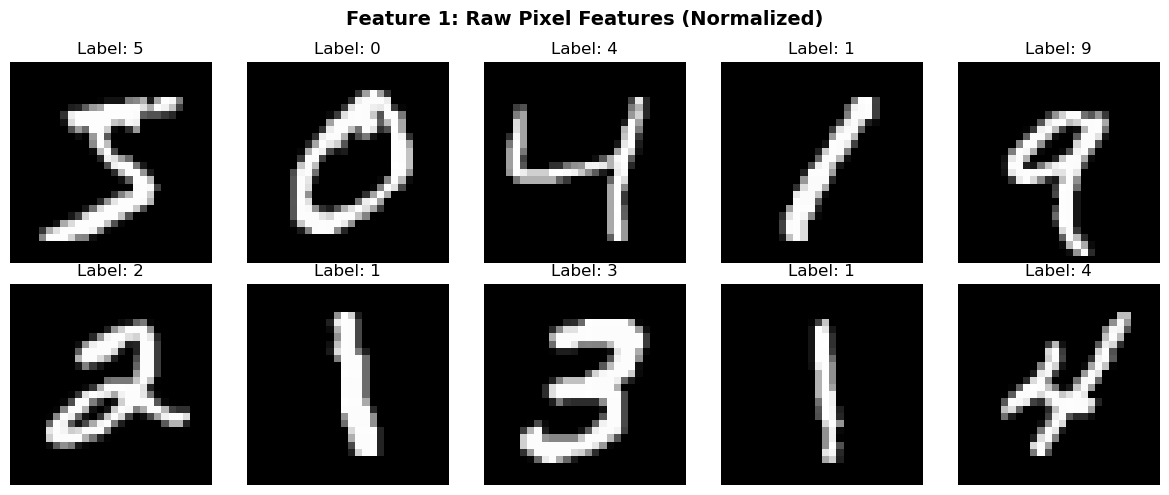

In [8]:
def create_raw_pixel_features(X):
    """
    Feature 1: Raw Pixel Features
    Flatten ảnh 28x28 thành vector 784 chiều và normalize
    
    Args:
        X: Images array, shape (N, 28, 28)
    
    Returns:
        Features array, shape (N, 784)
    """
    N = X.shape[0]
    X_flat = X.reshape(N, -1)  # (N, 784)
    return X_flat

# Tạo Feature 1
X_train_f1 = create_raw_pixel_features(X_train_raw)
X_test_f1 = create_raw_pixel_features(X_test_raw)

print("Feature 1 - Raw Pixels")
print(f"   Training shape: {X_train_f1.shape}")
print(f"   Test shape: {X_test_f1.shape}")
print(f"   Feature dimension: {X_train_f1.shape[1]}")

# Visualize một vài samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Feature 1: Raw Pixel Features (Normalized)', fontsize=14, fontweight='bold')
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train_raw[i], cmap='gray')
    ax.set_title(f'Label: {y_train_raw[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Feature Design 2: Edge Detection Features

**Cơ chế:**
- Sử dụng Sobel operator để phát hiện biên cạnh
- Sobel X: phát hiện biên dọc (vertical edges)
- Sobel Y: phát hiện biên ngang (horizontal edges)
- Kết hợp: $\text{Edge Magnitude} = \sqrt{G_x^2 + G_y^2}$

**Lý do:**
- Chữ số được định nghĩa chủ yếu bởi đường nét và biên
- Edge features giúp model tập trung vào cấu trúc quan trọng
- Giảm ảnh hưởng của variations về độ sáng

**Ưu điểm:**
- Robust với intensity variations
- Nắm bắt cấu trúc hình dạng tốt
- Giảm noise trong vùng uniform

**Nhược điểm:**
- Mất thông tin về texture và gradient mịn
- Nhạy cảm với độ dày của nét vẽ

⏳ Đang tạo Edge Features...
Feature 2 - Edge Detection (Sobel)
   Training shape: (60000, 784)
   Test shape: (10000, 784)
   Processing time: 1.42s
Feature 2 - Edge Detection (Sobel)
   Training shape: (60000, 784)
   Test shape: (10000, 784)
   Processing time: 1.42s


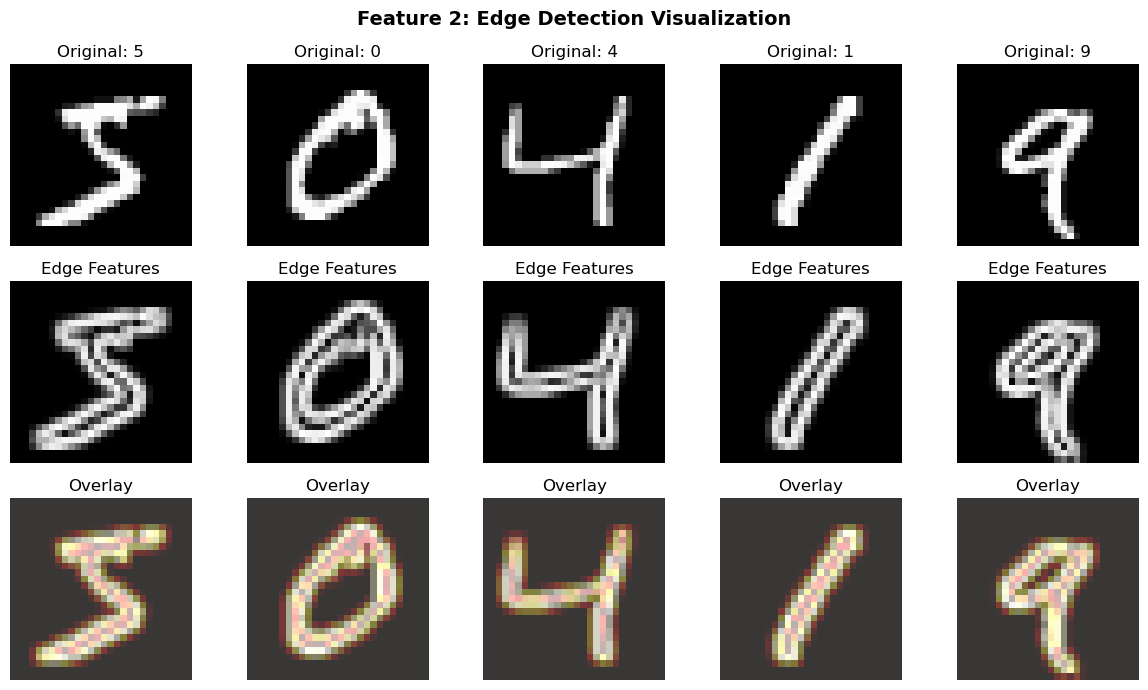

In [9]:
def create_edge_features(X):
    """
    Feature 2: Edge Detection Features sử dụng Sobel operator
    
    Args:
        X: Images array, shape (N, 28, 28), normalized [0, 1]
    
    Returns:
        Edge features array, shape (N, 784)
    """
    N = X.shape[0]
    edge_features = np.zeros((N, 28, 28), dtype=np.float32)
    
    for i in range(N):
        img = X[i]
        
        # Chuyển về uint8 cho OpenCV
        img_uint8 = (img * 255).astype(np.uint8)
        
        # Sobel edge detection
        sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)  # Vertical edges
        sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)  # Horizontal edges
        
        # Combine: Edge magnitude
        edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        # Normalize về [0, 1]
        if edge_magnitude.max() > 0:
            edge_magnitude = edge_magnitude / edge_magnitude.max()
        
        edge_features[i] = edge_magnitude
    
    # Flatten
    return edge_features.reshape(N, -1)

# Tạo Feature 2
print("⏳ Đang tạo Edge Features...")
start_time = time.time()
X_train_f2 = create_edge_features(X_train_raw)
X_test_f2 = create_edge_features(X_test_raw)
elapsed = time.time() - start_time

print(f"Feature 2 - Edge Detection (Sobel)")
print(f"   Training shape: {X_train_f2.shape}")
print(f"   Test shape: {X_test_f2.shape}")
print(f"   Processing time: {elapsed:.2f}s")

# Visualize Edge Detection
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
fig.suptitle('Feature 2: Edge Detection Visualization', fontsize=14, fontweight='bold')

for i in range(5):
    # Original
    axes[0, i].imshow(X_train_raw[i], cmap='gray')
    axes[0, i].set_title(f'Original: {y_train_raw[i]}')
    axes[0, i].axis('off')
    
    # Edge features
    edge_img = X_train_f2[i].reshape(28, 28)
    axes[1, i].imshow(edge_img, cmap='gray')
    axes[1, i].set_title('Edge Features')
    axes[1, i].axis('off')
    
    # Overlay
    axes[2, i].imshow(X_train_raw[i], cmap='gray', alpha=0.7)
    axes[2, i].imshow(edge_img, cmap='hot', alpha=0.3)
    axes[2, i].set_title('Overlay')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

### Feature Design 3: Dimensionality Reduction (PCA)

**Cơ chế PCA (Principal Component Analysis):**

1. **Centering data**: $\tilde{X} = X - \mu$
2. **Covariance matrix**: $C = \frac{1}{N-1}\tilde{X}^T\tilde{X}$
3. **Eigendecomposition**: $C\mathbf{v}_i = \lambda_i\mathbf{v}_i$
4. **Projection**: $X_{\text{reduced}} = \tilde{X} \cdot V_k$

Trong đó:
- $V_k$: Ma trận k eigenvectors tương ứng với k eigenvalues lớn nhất
- Giữ lại thành phần có variance cao (thông tin quan trọng)

**Lý do:**
- Giảm chiều từ 784 xuống ~100-200 chiều
- Loại bỏ redundant information
- Giảm overfitting và tăng tốc training

**Ưu điểm:**
- Giảm computational cost đáng kể
- Giữ lại variance chính (>90%)
- Decorrelate features
- Giảm noise

**Nhược điểm:**
- Mất một phần thông tin
- Giả định linear relationships
- Feature không còn interpretable

In [10]:
class PCA:
    """
    Principal Component Analysis - Implementation từ đầu bằng NumPy
    """
    
    def __init__(self, n_components=100):
        """
        Args:
            n_components: Số lượng principal components cần giữ lại
        """
        self.n_components = n_components
        self.mean = None
        self.components = None  # Eigenvectors
        self.explained_variance = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        """
        Fit PCA trên training data
        
        Args:
            X: Training data, shape (N, d)
        """
        N, d = X.shape
        
        # Step 1: Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Step 2: Compute covariance matrix
        # Cov = (1/(N-1)) * X_centered.T @ X_centered
        cov_matrix = (X_centered.T @ X_centered) / (N - 1)
        
        # Step 3: Eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Step 4: Sort by eigenvalues (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Step 5: Select top k components
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance = eigenvalues[:self.n_components]
        
        # Calculate variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = self.explained_variance / total_variance
        
        return self
    
    def transform(self, X):
        """
        Transform data sang không gian PCA
        
        Args:
            X: Data to transform, shape (N, d)
        
        Returns:
            X_transformed: Transformed data, shape (N, n_components)
        """
        X_centered = X - self.mean
        return X_centered @ self.components
    
    def fit_transform(self, X):
        """Fit và transform trong một lần"""
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X_reduced):
        """
        Reconstruct data từ reduced representation
        
        Args:
            X_reduced: Reduced data, shape (N, n_components)
        
        Returns:
            X_reconstructed: Reconstructed data, shape (N, d)
        """
        return X_reduced @ self.components.T + self.mean

print("PCA class đã được định nghĩa")

PCA class đã được định nghĩa


⏳ Đang fit PCA trên training data...
Feature 3 - PCA Dimensionality Reduction
   Original dimensions: 784
   Reduced dimensions: 150
   Training shape: (60000, 150)
   Test shape: (10000, 150)
   Processing time: 0.43s
   Variance explained: 0.9484 (94.84%)
Feature 3 - PCA Dimensionality Reduction
   Original dimensions: 784
   Reduced dimensions: 150
   Training shape: (60000, 150)
   Test shape: (10000, 150)
   Processing time: 0.43s
   Variance explained: 0.9484 (94.84%)


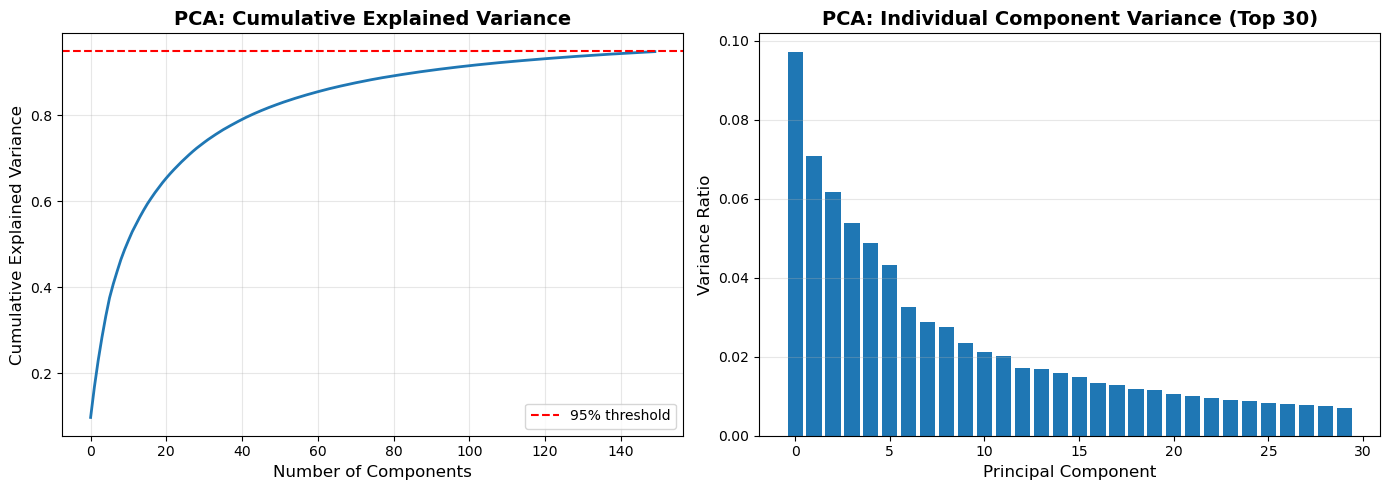

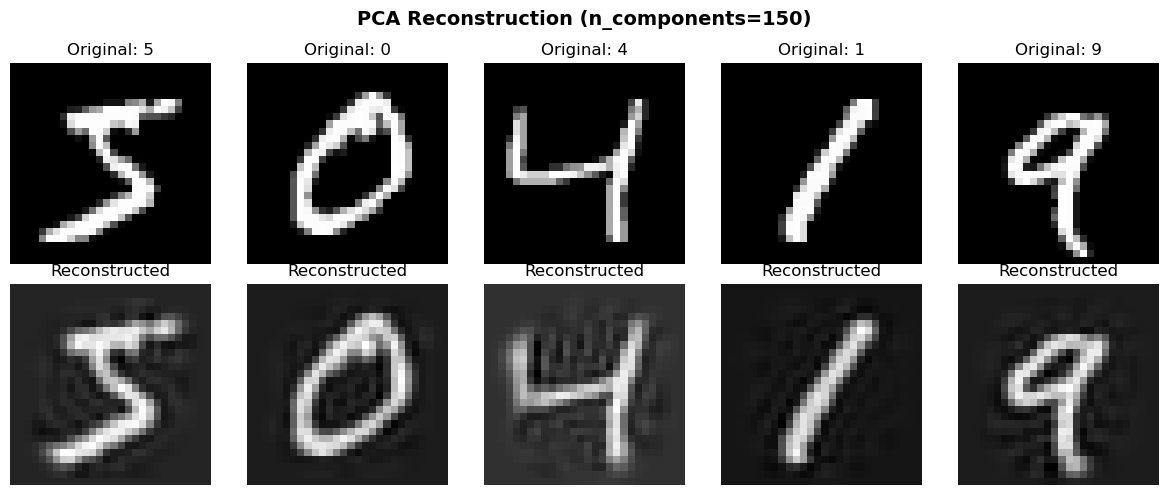

In [11]:
# Áp dụng PCA lên raw pixel features
n_components = 150  # Giữ lại 150 principal components

print("⏳ Đang fit PCA trên training data...")
start_time = time.time()

pca = PCA(n_components=n_components)
X_train_f3 = pca.fit_transform(X_train_f1)
X_test_f3 = pca.transform(X_test_f1)

elapsed = time.time() - start_time

print(f"Feature 3 - PCA Dimensionality Reduction")
print(f"   Original dimensions: {X_train_f1.shape[1]}")
print(f"   Reduced dimensions: {X_train_f3.shape[1]}")
print(f"   Training shape: {X_train_f3.shape}")
print(f"   Test shape: {X_test_f3.shape}")
print(f"   Processing time: {elapsed:.2f}s")
print(f"   Variance explained: {np.sum(pca.explained_variance_ratio):.4f} ({np.sum(pca.explained_variance_ratio)*100:.2f}%)")

# Visualize explained variance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio), linewidth=2)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA: Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(min(30, n_components)), pca.explained_variance_ratio[:30])
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Variance Ratio', fontsize=12)
plt.title('PCA: Individual Component Variance (Top 30)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Visualize reconstruction
n_samples = 5
X_reconstructed = pca.inverse_transform(X_train_f3[:n_samples])

fig, axes = plt.subplots(2, n_samples, figsize=(12, 5))
fig.suptitle(f'PCA Reconstruction (n_components={n_components})', fontsize=14, fontweight='bold')

for i in range(n_samples):
    # Original
    axes[0, i].imshow(X_train_f1[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Original: {y_train_raw[i]}')
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## PHẦN 5: TRAINING & EVALUATION

### 5.1 Evaluation Metrics Implementation

In [12]:
def compute_confusion_matrix(y_true, y_pred, n_classes=10):
    """
    Tính confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        n_classes: Number of classes
    
    Returns:
        Confusion matrix, shape (n_classes, n_classes)
    """
    cm = np.zeros((n_classes, n_classes), dtype=np.int32)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm

def compute_metrics(y_true, y_pred, n_classes=10, average='macro'):
    """
    Tính Accuracy, Precision, Recall, F1-score cho multi-class
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        n_classes: Number of classes
        average: 'macro' hoặc 'weighted'
    
    Returns:
        Dictionary chứa các metrics
    """
    cm = compute_confusion_matrix(y_true, y_pred, n_classes)
    
    # Accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Per-class metrics
    precision_per_class = np.zeros(n_classes)
    recall_per_class = np.zeros(n_classes)
    f1_per_class = np.zeros(n_classes)
    
    for i in range(n_classes):
        # True Positives, False Positives, False Negatives
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        
        # Precision = TP / (TP + FP)
        precision_per_class[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Recall = TP / (TP + FN)
        recall_per_class[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        if precision_per_class[i] + recall_per_class[i] > 0:
            f1_per_class[i] = 2 * (precision_per_class[i] * recall_per_class[i]) / \
                              (precision_per_class[i] + recall_per_class[i])
        else:
            f1_per_class[i] = 0
    
    # Macro average (unweighted mean)
    if average == 'macro':
        precision = np.mean(precision_per_class)
        recall = np.mean(recall_per_class)
        f1 = np.mean(f1_per_class)
    
    # Weighted average (weighted by support)
    elif average == 'weighted':
        support = np.sum(cm, axis=1)
        precision = np.sum(precision_per_class * support) / np.sum(support)
        recall = np.sum(recall_per_class * support) / np.sum(support)
        f1 = np.sum(f1_per_class * support) / np.sum(support)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

def plot_confusion_matrix(cm, title='Confusion Matrix', figsize=(10, 8)):
    """
    Vẽ confusion matrix
    
    Args:
        cm: Confusion matrix
        title: Title của plot
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
                xticklabels=range(10), yticklabels=range(10),
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_metrics(metrics, feature_name):
    """In metrics ra màn hình"""
    print(f"\n{'='*60}")
    print(f"  {feature_name}")
    print(f"{'='*60}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")
    print(f"{'='*60}")

print("Evaluation functions đã được định nghĩa")

Evaluation functions đã được định nghĩa


### 5.2 Training Model 1: Raw Pixel Features

In [13]:
print("Training Model 1: Raw Pixel Features")
print("="*60)

# Hyperparameters
learning_rate = 0.1
reg_lambda = 0.0001
epochs = 100
batch_size = 128

# Initialize model
model_f1 = SoftmaxRegression(
    n_features=X_train_f1.shape[1],
    n_classes=10,
    learning_rate=learning_rate,
    reg_lambda=reg_lambda
)

# Train
start_time = time.time()
model_f1.train(
    X_train_f1, y_train_raw,
    X_val=X_test_f1, y_val=y_test_raw,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)
training_time_f1 = time.time() - start_time

print(f"\n⏱️  Training time: {training_time_f1:.2f}s")

# Evaluate
y_pred_f1 = model_f1.predict(X_test_f1)
metrics_f1 = compute_metrics(y_test_raw, y_pred_f1, average='macro')
print_metrics(metrics_f1, "Model 1 - Raw Pixel Features")

Training Model 1: Raw Pixel Features
Epoch 10/100 - Loss: 0.2910 - Acc: 0.9203 - Val_Loss: 0.2839 - Val_Acc: 0.9209
Epoch 10/100 - Loss: 0.2910 - Acc: 0.9203 - Val_Loss: 0.2839 - Val_Acc: 0.9209
Epoch 20/100 - Loss: 0.2732 - Acc: 0.9249 - Val_Loss: 0.2746 - Val_Acc: 0.9225
Epoch 20/100 - Loss: 0.2732 - Acc: 0.9249 - Val_Loss: 0.2746 - Val_Acc: 0.9225
Epoch 30/100 - Loss: 0.2649 - Acc: 0.9275 - Val_Loss: 0.2687 - Val_Acc: 0.9242
Epoch 30/100 - Loss: 0.2649 - Acc: 0.9275 - Val_Loss: 0.2687 - Val_Acc: 0.9242
Epoch 40/100 - Loss: 0.2596 - Acc: 0.9292 - Val_Loss: 0.2676 - Val_Acc: 0.9245
Epoch 40/100 - Loss: 0.2596 - Acc: 0.9292 - Val_Loss: 0.2676 - Val_Acc: 0.9245
Epoch 50/100 - Loss: 0.2558 - Acc: 0.9302 - Val_Loss: 0.2665 - Val_Acc: 0.9246
Epoch 50/100 - Loss: 0.2558 - Acc: 0.9302 - Val_Loss: 0.2665 - Val_Acc: 0.9246
Epoch 60/100 - Loss: 0.2529 - Acc: 0.9313 - Val_Loss: 0.2658 - Val_Acc: 0.9246
Epoch 60/100 - Loss: 0.2529 - Acc: 0.9313 - Val_Loss: 0.2658 - Val_Acc: 0.9246
Epoch 70/100 - 

### 5.3 Training Model 2: Edge Detection Features

In [14]:
print("Training Model 2: Edge Detection Features")
print("="*60)

# Initialize model
model_f2 = SoftmaxRegression(
    n_features=X_train_f2.shape[1],
    n_classes=10,
    learning_rate=learning_rate,
    reg_lambda=reg_lambda
)

# Train
start_time = time.time()
model_f2.train(
    X_train_f2, y_train_raw,
    X_val=X_test_f2, y_val=y_test_raw,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)
training_time_f2 = time.time() - start_time

print(f"\n⏱️  Training time: {training_time_f2:.2f}s")

# Evaluate
y_pred_f2 = model_f2.predict(X_test_f2)
metrics_f2 = compute_metrics(y_test_raw, y_pred_f2, average='macro')
print_metrics(metrics_f2, "Model 2 - Edge Detection Features")

Training Model 2: Edge Detection Features
Epoch 10/100 - Loss: 0.3766 - Acc: 0.8898 - Val_Loss: 0.3710 - Val_Acc: 0.8933
Epoch 10/100 - Loss: 0.3766 - Acc: 0.8898 - Val_Loss: 0.3710 - Val_Acc: 0.8933
Epoch 20/100 - Loss: 0.3548 - Acc: 0.8949 - Val_Loss: 0.3590 - Val_Acc: 0.8961
Epoch 20/100 - Loss: 0.3548 - Acc: 0.8949 - Val_Loss: 0.3590 - Val_Acc: 0.8961
Epoch 30/100 - Loss: 0.3442 - Acc: 0.8992 - Val_Loss: 0.3512 - Val_Acc: 0.8985
Epoch 30/100 - Loss: 0.3442 - Acc: 0.8992 - Val_Loss: 0.3512 - Val_Acc: 0.8985
Epoch 40/100 - Loss: 0.3368 - Acc: 0.9003 - Val_Loss: 0.3511 - Val_Acc: 0.8984
Epoch 40/100 - Loss: 0.3368 - Acc: 0.9003 - Val_Loss: 0.3511 - Val_Acc: 0.8984
Epoch 50/100 - Loss: 0.3322 - Acc: 0.9027 - Val_Loss: 0.3482 - Val_Acc: 0.9003
Epoch 50/100 - Loss: 0.3322 - Acc: 0.9027 - Val_Loss: 0.3482 - Val_Acc: 0.9003
Epoch 60/100 - Loss: 0.3282 - Acc: 0.9033 - Val_Loss: 0.3462 - Val_Acc: 0.9001
Epoch 60/100 - Loss: 0.3282 - Acc: 0.9033 - Val_Loss: 0.3462 - Val_Acc: 0.9001
Epoch 70/1

### 5.4 Training Model 3: PCA Features

In [15]:
print("Training Model 3: PCA Features")
print("="*60)

# Initialize model
model_f3 = SoftmaxRegression(
    n_features=X_train_f3.shape[1],
    n_classes=10,
    learning_rate=learning_rate,
    reg_lambda=reg_lambda
)

# Train
start_time = time.time()
model_f3.train(
    X_train_f3, y_train_raw,
    X_val=X_test_f3, y_val=y_test_raw,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)
training_time_f3 = time.time() - start_time

print(f"\n⏱️  Training time: {training_time_f3:.2f}s")

# Evaluate
y_pred_f3 = model_f3.predict(X_test_f3)
metrics_f3 = compute_metrics(y_test_raw, y_pred_f3, average='macro')
print_metrics(metrics_f3, "Model 3 - PCA Features")

Training Model 3: PCA Features
Epoch 10/100 - Loss: 0.3004 - Acc: 0.9159 - Val_Loss: 0.2906 - Val_Acc: 0.9173
Epoch 10/100 - Loss: 0.3004 - Acc: 0.9159 - Val_Loss: 0.2906 - Val_Acc: 0.9173
Epoch 20/100 - Loss: 0.2844 - Acc: 0.9207 - Val_Loss: 0.2799 - Val_Acc: 0.9202
Epoch 20/100 - Loss: 0.2844 - Acc: 0.9207 - Val_Loss: 0.2799 - Val_Acc: 0.9202
Epoch 30/100 - Loss: 0.2780 - Acc: 0.9226 - Val_Loss: 0.2762 - Val_Acc: 0.9219
Epoch 30/100 - Loss: 0.2780 - Acc: 0.9226 - Val_Loss: 0.2762 - Val_Acc: 0.9219
Epoch 40/100 - Loss: 0.2750 - Acc: 0.9231 - Val_Loss: 0.2742 - Val_Acc: 0.9221
Epoch 40/100 - Loss: 0.2750 - Acc: 0.9231 - Val_Loss: 0.2742 - Val_Acc: 0.9221
Epoch 50/100 - Loss: 0.2727 - Acc: 0.9239 - Val_Loss: 0.2726 - Val_Acc: 0.9223
Epoch 50/100 - Loss: 0.2727 - Acc: 0.9239 - Val_Loss: 0.2726 - Val_Acc: 0.9223
Epoch 60/100 - Loss: 0.2714 - Acc: 0.9246 - Val_Loss: 0.2723 - Val_Acc: 0.9224
Epoch 60/100 - Loss: 0.2714 - Acc: 0.9246 - Val_Loss: 0.2723 - Val_Acc: 0.9224
Epoch 70/100 - Loss: 

## PHẦN 6: MODEL EVALUATION AND ANALYSIS

### Objective
Đánh giá chi tiết performance của 3 models với các metrics chuẩn và phân tích kết quả dựa trên dữ liệu thực nghiệm.

### 6.1 Classification Metrics Analysis

Đánh giá chi tiết với các metrics: **Accuracy, Precision, Recall, F1-Score** (macro-averaged và per-class)

In [16]:
# ========================================
# 6.1.1 DETAILED METRICS FOR ALL MODELS
# ========================================

print("="*80)
print("                    CLASSIFICATION METRICS SUMMARY")
print("="*80)

models_data = [
    ("Raw Pixel Features", metrics_f1, y_pred_f1),
    ("Edge Detection Features", metrics_f2, y_pred_f2),
    ("PCA Features", metrics_f3, y_pred_f3)
]

for model_name, metrics, y_pred in models_data:
    print(f"\n{'='*80}")
    print(f"  {model_name.upper()}")
    print(f"{'='*80}")
    
    # Overall metrics
    print(f"\n  Overall Performance:")
    print(f"     Accuracy:  {metrics['accuracy']:.6f} ({metrics['accuracy']*100:.2f}%)")
    print(f"     Precision: {metrics['precision']:.6f} (Macro-averaged)")
    print(f"     Recall:    {metrics['recall']:.6f} (Macro-averaged)")
    print(f"     F1-Score:  {metrics['f1_score']:.6f} (Macro-averaged)")
    
    # Per-class breakdown
    print(f"\n  Per-Class Performance:")
    print(f"     {'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"     {'-'*60}")
    
    cm = metrics['confusion_matrix']
    for i in range(10):
        support = np.sum(cm[i, :])
        print(f"     {i:<8} {metrics['precision_per_class'][i]:<12.4f} "
              f"{metrics['recall_per_class'][i]:<12.4f} "
              f"{metrics['f1_per_class'][i]:<12.4f} {support:<10}")
    
    # Best and worst performing classes
    best_class = np.argmax(metrics['f1_per_class'])
    worst_class = np.argmin(metrics['f1_per_class'])
    
    print(f"\n  Best performing class:  {best_class} (F1={metrics['f1_per_class'][best_class]:.4f})")
    print(f"  Worst performing class: {worst_class} (F1={metrics['f1_per_class'][worst_class]:.4f})")

print("\n" + "="*80)

                    CLASSIFICATION METRICS SUMMARY

  RAW PIXEL FEATURES

  Overall Performance:
     Accuracy:  0.926800 (92.68%)
     Precision: 0.926127 (Macro-averaged)
     Recall:    0.925772 (Macro-averaged)
     F1-Score:  0.925811 (Macro-averaged)

  Per-Class Performance:
     Class    Precision    Recall       F1-Score     Support   
     ------------------------------------------------------------
     0        0.9533       0.9786       0.9658       980       
     1        0.9661       0.9780       0.9720       1135      
     2        0.9319       0.9012       0.9163       1032      
     3        0.9150       0.9059       0.9104       1010      
     4        0.9347       0.9328       0.9337       982       
     5        0.9088       0.8711       0.8895       892       
     6        0.9431       0.9509       0.9470       958       
     7        0.9210       0.9300       0.9255       1028      
     8        0.8652       0.9025       0.8834       974       
     9     

### 6.2 Confusion Matrix Visualization and Analysis

📊 Confusion Matrices



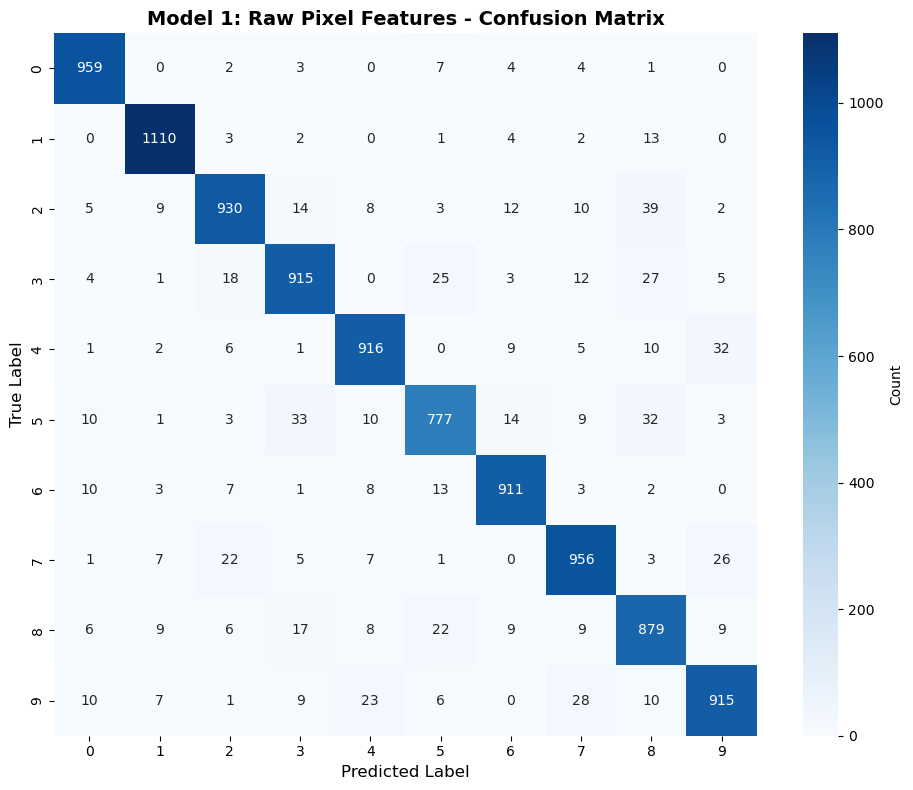

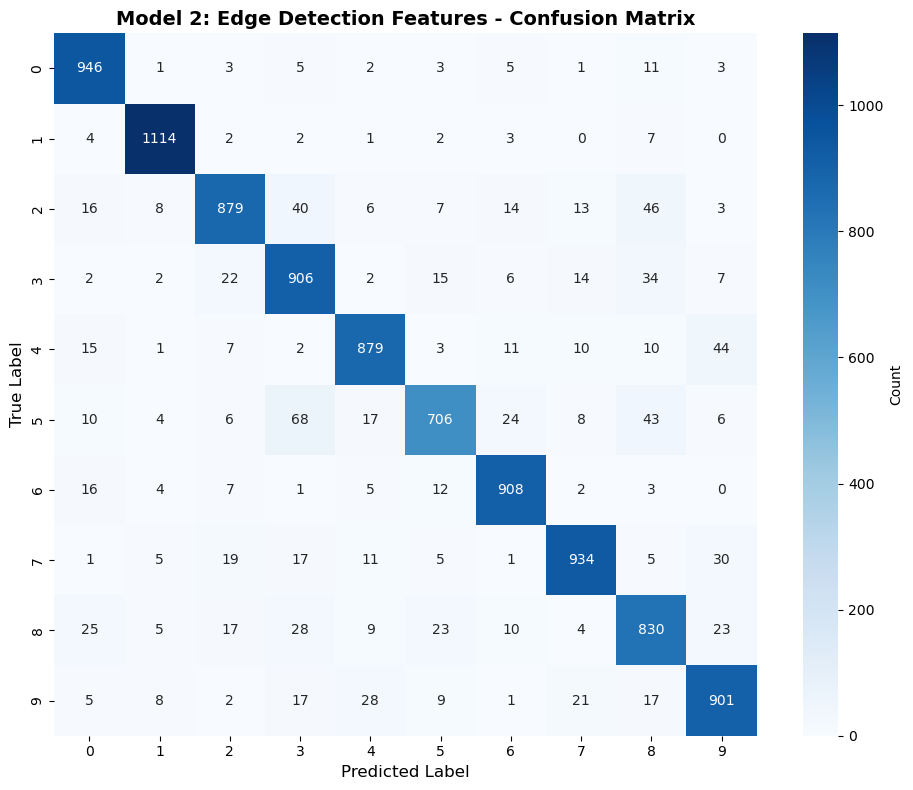

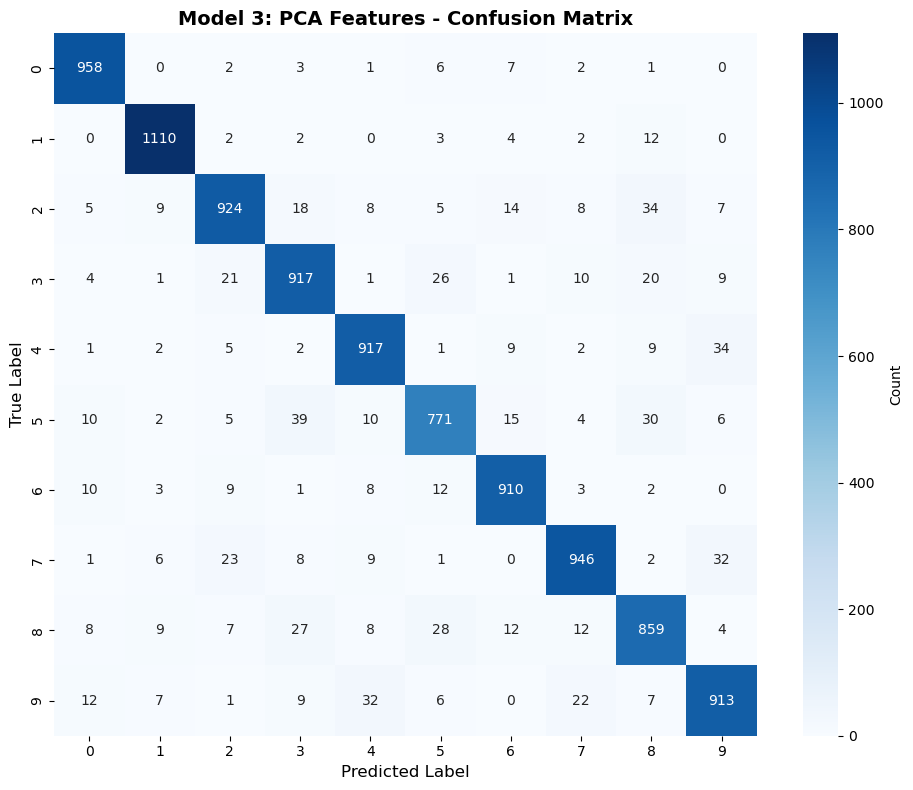

In [17]:
# Plot Confusion Matrices
print("📊 Confusion Matrices\n")

plot_confusion_matrix(metrics_f1['confusion_matrix'], 
                     title='Model 1: Raw Pixel Features - Confusion Matrix')

plot_confusion_matrix(metrics_f2['confusion_matrix'],
                     title='Model 2: Edge Detection Features - Confusion Matrix')

plot_confusion_matrix(metrics_f3['confusion_matrix'],
                     title='Model 3: PCA Features - Confusion Matrix')

In [18]:
# Comparison Table
comparison_data = {
    'Feature Type': ['Raw Pixels', 'Edge Detection', 'PCA'],
    'Feature Dim': [X_train_f1.shape[1], X_train_f2.shape[1], X_train_f3.shape[1]],
    'Accuracy': [metrics_f1['accuracy'], metrics_f2['accuracy'], metrics_f3['accuracy']],
    'Precision': [metrics_f1['precision'], metrics_f2['precision'], metrics_f3['precision']],
    'Recall': [metrics_f1['recall'], metrics_f2['recall'], metrics_f3['recall']],
    'F1-Score': [metrics_f1['f1_score'], metrics_f2['f1_score'], metrics_f3['f1_score']],
    'Training Time (s)': [training_time_f1, training_time_f2, training_time_f3]
}

print("\n" + "="*90)
print("                          MODEL COMPARISON SUMMARY")
print("="*90)
print(f"{'Feature Type':<20} {'Dim':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Time(s)':<10}")
print("-"*90)

for i in range(3):
    print(f"{comparison_data['Feature Type'][i]:<20} "
          f"{comparison_data['Feature Dim'][i]:<8} "
          f"{comparison_data['Accuracy'][i]:<12.4f} "
          f"{comparison_data['Precision'][i]:<12.4f} "
          f"{comparison_data['Recall'][i]:<12.4f} "
          f"{comparison_data['F1-Score'][i]:<12.4f} "
          f"{comparison_data['Training Time (s)'][i]:<10.2f}")

print("="*90)

# Find best model
best_idx = np.argmax(comparison_data['Accuracy'])
print(f"\nBEST MODEL: {comparison_data['Feature Type'][best_idx]} "
      f"(Accuracy: {comparison_data['Accuracy'][best_idx]:.4f})")
print("="*90)


                          MODEL COMPARISON SUMMARY
Feature Type         Dim      Accuracy     Precision    Recall       F1-Score     Time(s)   
------------------------------------------------------------------------------------------
Raw Pixels           784      0.9268       0.9261       0.9258       0.9258       42.63     
Edge Detection       784      0.9003       0.9000       0.8984       0.8985       42.11     
PCA                  150      0.9225       0.9215       0.9214       0.9213       14.05     

BEST MODEL: Raw Pixels (Accuracy: 0.9268)


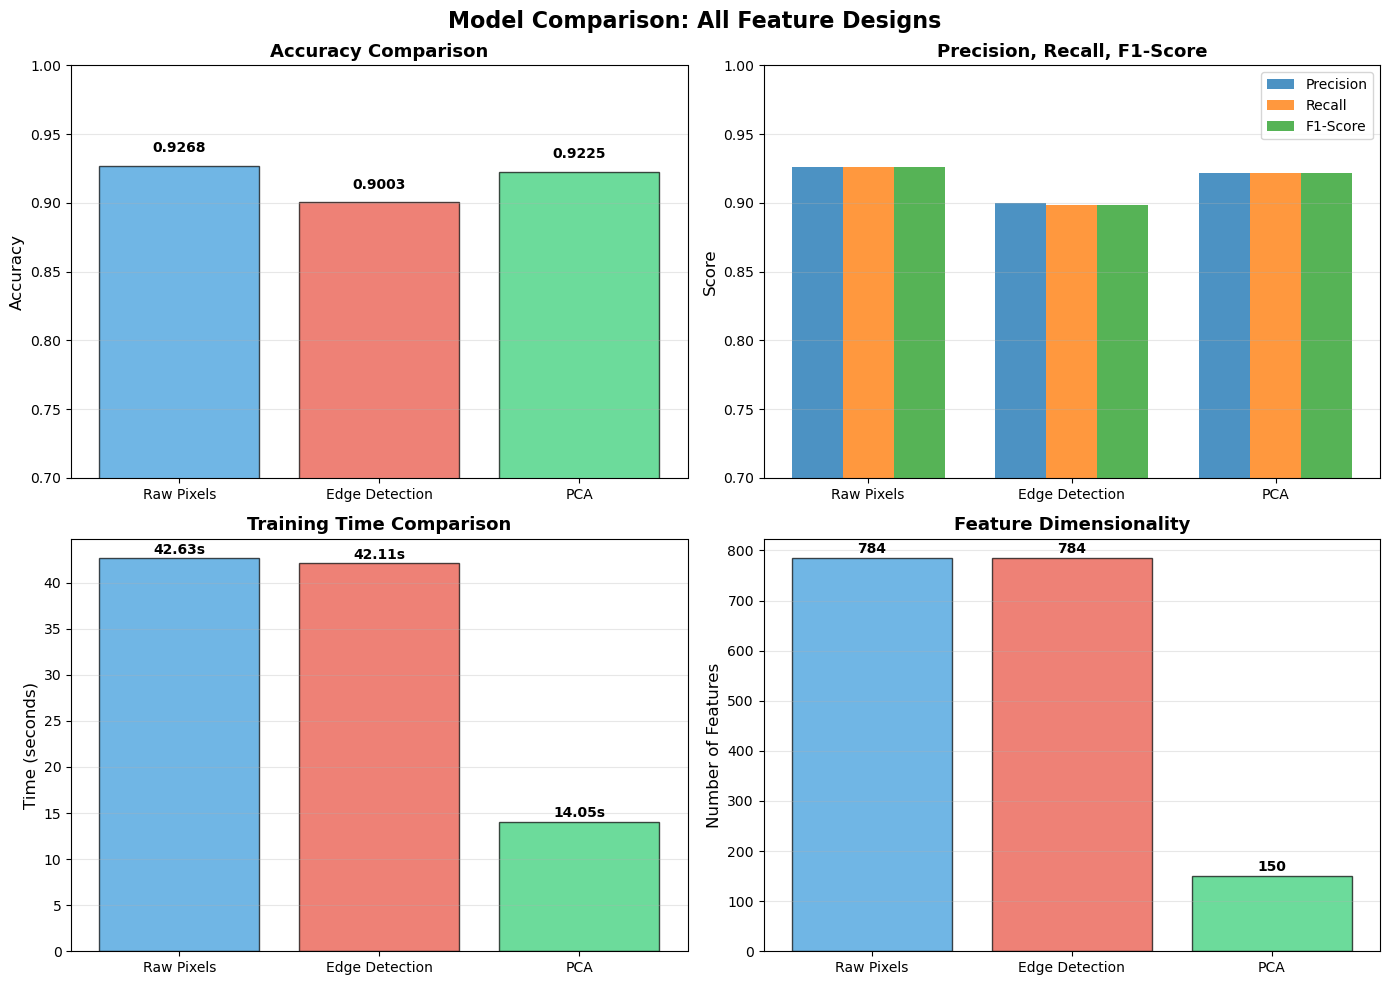

In [19]:
# Visualize Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison: All Feature Designs', fontsize=16, fontweight='bold')

models = ['Raw Pixels', 'Edge Detection', 'PCA']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Accuracy
axes[0, 0].bar(models, comparison_data['Accuracy'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0.7, 1.0])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_data['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Precision, Recall, F1
metrics_comparison = np.array([
    comparison_data['Precision'],
    comparison_data['Recall'],
    comparison_data['F1-Score']
])

x = np.arange(len(models))
width = 0.25

axes[0, 1].bar(x - width, metrics_comparison[0], width, label='Precision', alpha=0.8)
axes[0, 1].bar(x, metrics_comparison[1], width, label='Recall', alpha=0.8)
axes[0, 1].bar(x + width, metrics_comparison[2], width, label='F1-Score', alpha=0.8)
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Precision, Recall, F1-Score', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].legend()
axes[0, 1].set_ylim([0.7, 1.0])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Training Time
axes[1, 0].bar(models, comparison_data['Training Time (s)'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_data['Training Time (s)']):
    axes[1, 0].text(i, v + 0.5, f'{v:.2f}s', ha='center', fontweight='bold')

# Feature Dimensions
axes[1, 1].bar(models, comparison_data['Feature Dim'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Number of Features', fontsize=12)
axes[1, 1].set_title('Feature Dimensionality', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_data['Feature Dim']):
    axes[1, 1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

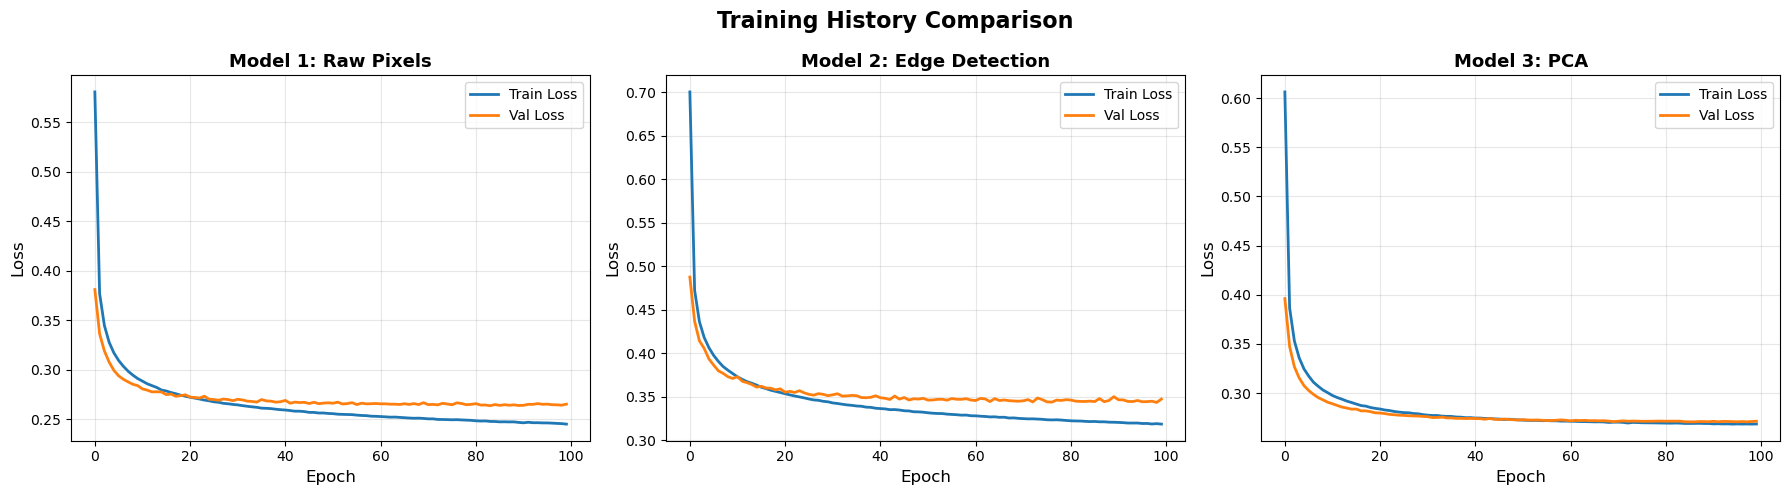

In [20]:
# Training History Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

# Model 1
axes[0].plot(model_f1.train_loss_history, label='Train Loss', linewidth=2)
axes[0].plot(model_f1.val_loss_history, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model 1: Raw Pixels', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model 2
axes[1].plot(model_f2.train_loss_history, label='Train Loss', linewidth=2)
axes[1].plot(model_f2.val_loss_history, label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model 2: Edge Detection', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Model 3
axes[2].plot(model_f3.train_loss_history, label='Train Loss', linewidth=2)
axes[2].plot(model_f3.val_loss_history, label='Val Loss', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].set_title('Model 3: PCA', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

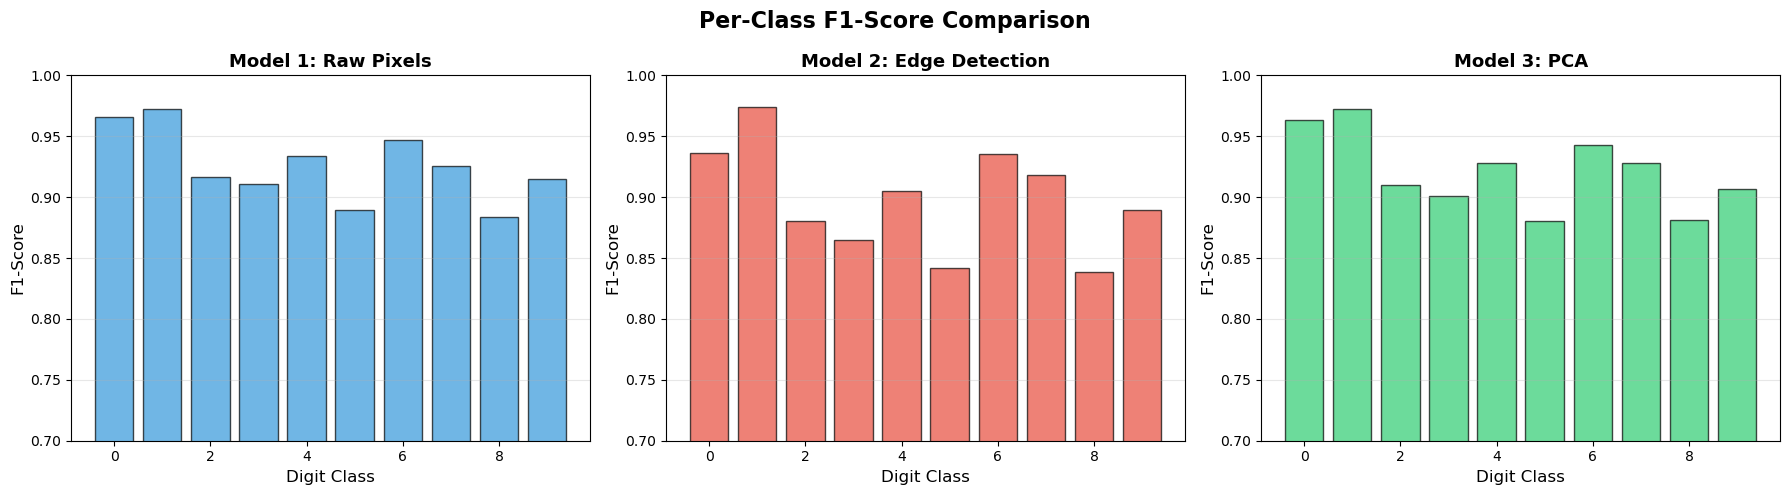

In [21]:
# Per-class Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Per-Class F1-Score Comparison', fontsize=16, fontweight='bold')

classes = list(range(10))

axes[0].bar(classes, metrics_f1['f1_per_class'], color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Digit Class', fontsize=12)
axes[0].set_ylabel('F1-Score', fontsize=12)
axes[0].set_title('Model 1: Raw Pixels', fontsize=13, fontweight='bold')
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(classes, metrics_f2['f1_per_class'], color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Digit Class', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Model 2: Edge Detection', fontsize=13, fontweight='bold')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(classes, metrics_f3['f1_per_class'], color='#2ecc71', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Digit Class', fontsize=12)
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('Model 3: PCA', fontsize=13, fontweight='bold')
axes[2].set_ylim([0.7, 1.0])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

📊 Prediction Comparison - Same Samples Across All Models



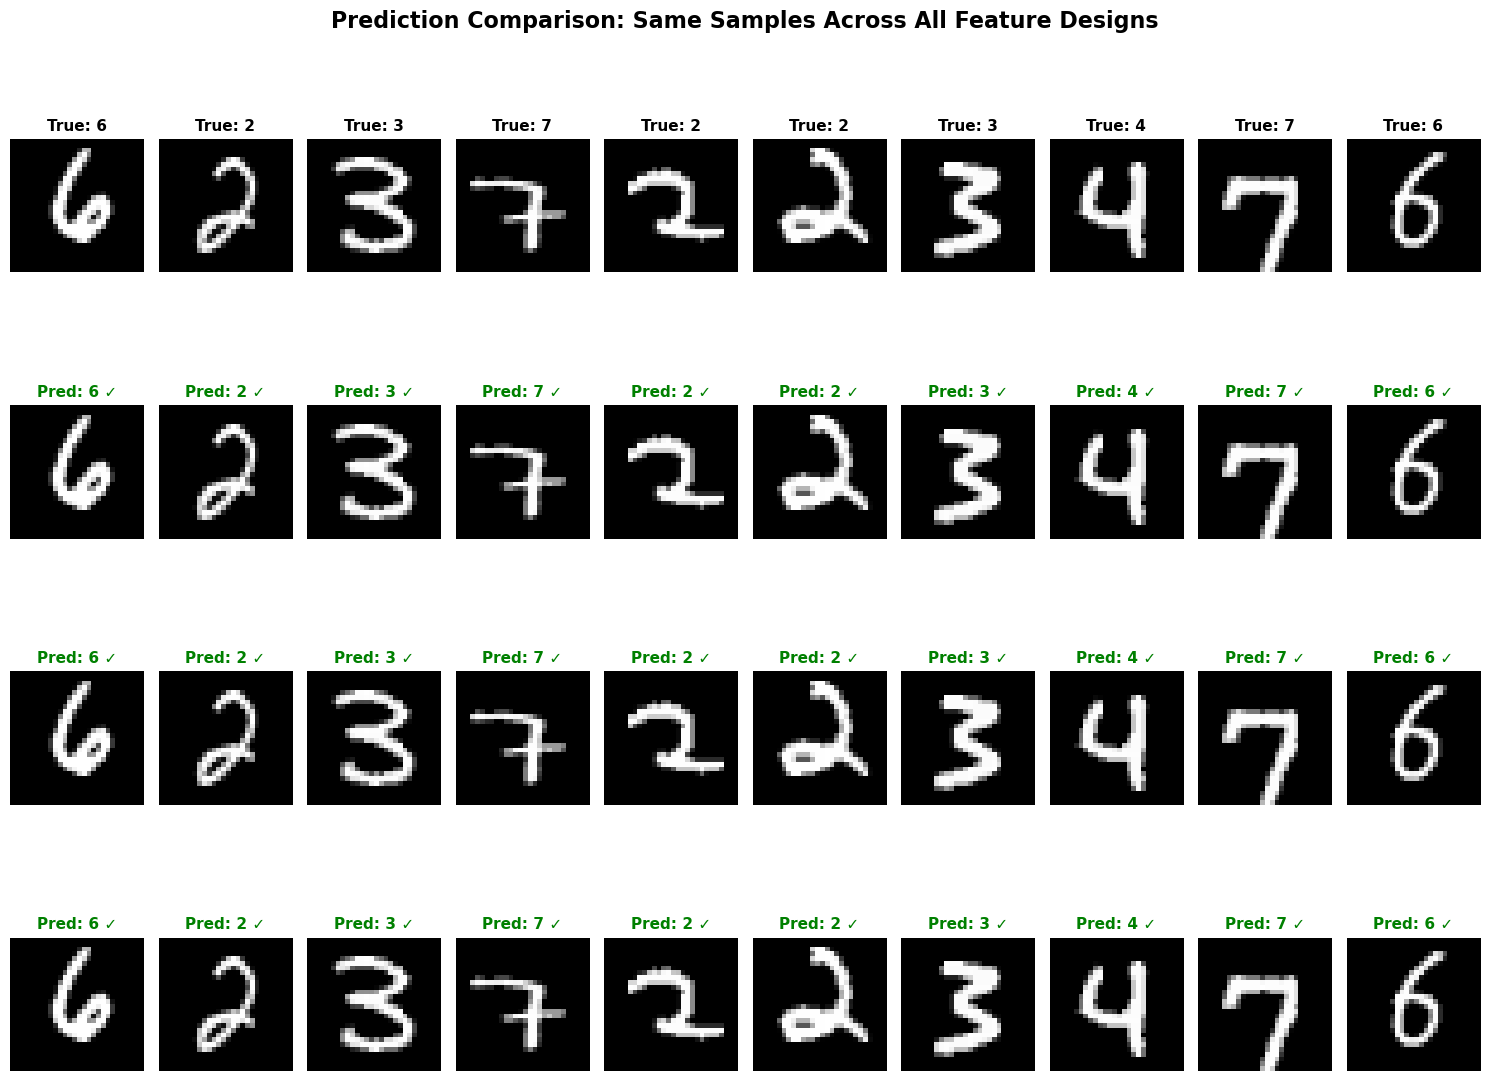

In [22]:
# ========================================
# VISUALIZE PREDICTIONS COMPARISON
# ========================================

def show_predictions_comparison(X_original, y_true, y_pred_list, model_names, n_samples=5):
    """
    Hiển thị predictions của nhiều models cho CÙNG samples
    
    Args:
        X_original: Original images
        y_true: True labels
        y_pred_list: List of predictions từ các models
        model_names: List of model names
        n_samples: Number of samples to show
    """
    n_models = len(y_pred_list)
    
    fig, axes = plt.subplots(n_models + 1, n_samples, figsize=(15, 3 * (n_models + 1)))
    fig.suptitle('Prediction Comparison: Same Samples Across All Feature Designs', 
                 fontsize=16, fontweight='bold')
    
    # Chọn random samples (SAME for all models)
    np.random.seed(42)  # Fixed seed để reproducible
    indices = np.random.choice(len(y_true), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Row 0: Original images
        axes[0, i].imshow(X_original[idx], cmap='gray')
        axes[0, i].set_title(f'True: {y_true[idx]}', fontsize=11, fontweight='bold')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original\nImage', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
        
        # Rows 1-n: Predictions from each model
        for model_idx, (y_pred, model_name) in enumerate(zip(y_pred_list, model_names)):
            row = model_idx + 1
            axes[row, i].imshow(X_original[idx], cmap='gray')
            
            # Color: green nếu đúng, red nếu sai
            is_correct = (y_true[idx] == y_pred[idx])
            color = 'green' if is_correct else 'red'
            marker = '✓' if is_correct else '✗'
            
            axes[row, i].set_title(f'Pred: {y_pred[idx]} {marker}', 
                                  fontsize=11, color=color, fontweight='bold')
            axes[row, i].axis('off')
            
            # Label model name on first column
            if i == 0:
                axes[row, i].set_ylabel(model_name, fontsize=10, fontweight='bold', 
                                       rotation=0, ha='right', va='center')
    
    plt.tight_layout()
    plt.show()

# Show comparison cho cả 3 models với CÙNG samples
print("📊 Prediction Comparison - Same Samples Across All Models\n")

y_pred_list = [y_pred_f1, y_pred_f2, y_pred_f3]
model_names = [
    'Raw Pixels',
    'Edge Detection', 
    'PCA'
]

show_predictions_comparison(X_test_raw, y_test_raw, y_pred_list, model_names, n_samples=10)

## PHẦN 7: EXPORT MODEL FOR PRODUCTION

Export trained model và PCA transformer để sử dụng trong web application

In [23]:
import pickle
import os

# Tạo thư mục models nếu chưa có
models_dir = '../web/public/models'
os.makedirs(models_dir, exist_ok=True)

# ========================================
# 7.1 EXPORT PCA MODEL (Best performing)
# ========================================

# Prepare model data
model_data = {
    'model_type': 'softmax_regression_pca',
    'model': {
        'W': model_f3.W,  # Weights (150, 10)
        'b': model_f3.b,  # Bias (10,)
        'n_features': model_f3.n_features,
        'n_classes': model_f3.n_classes
    },
    'pca': {
        'mean': pca.mean,  # (784,)
        'components': pca.components,  # (784, 150)
        'n_components': pca.n_components,
        'explained_variance_ratio': pca.explained_variance_ratio
    },
    'metrics': {
        'accuracy': metrics_f3['accuracy'],
        'precision': metrics_f3['precision'],
        'recall': metrics_f3['recall'],
        'f1_score': metrics_f3['f1_score']
    },
    'metadata': {
        'training_samples': len(X_train_f1),
        'test_samples': len(X_test_f1),
        'learning_rate': learning_rate,
        'reg_lambda': reg_lambda,
        'epochs': epochs,
        'batch_size': batch_size
    }
}

# Save to pickle file
model_path = os.path.join(models_dir, 'softmax_pca_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model exported successfully!")
print(f"   📁 Location: {model_path}")
print(f"   📊 Model accuracy: {metrics_f3['accuracy']:.4f}")
print(f"   🔢 Feature dimensions: 784 → {pca.n_components}")
print(f"   💾 File size: {os.path.getsize(model_path) / 1024:.2f} KB")

# ========================================
# 7.2 VERIFY EXPORT (Load and test)
# ========================================

print("\n🔍 Verifying exported model...")

# Load model
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Reconstruct model
class LoadedSoftmaxRegression:
    def __init__(self, model_dict):
        self.W = model_dict['W']
        self.b = model_dict['b']
        self.n_features = model_dict['n_features']
        self.n_classes = model_dict['n_classes']
    
    def softmax(self, z):
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def predict(self, X):
        logits = X @ self.W + self.b
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)
    
    def predict_proba(self, X):
        logits = X @ self.W + self.b
        return self.softmax(logits)

# Reconstruct PCA
class LoadedPCA:
    def __init__(self, pca_dict):
        self.mean = pca_dict['mean']
        self.components = pca_dict['components']
        self.n_components = pca_dict['n_components']
    
    def transform(self, X):
        X_centered = X - self.mean
        return X_centered @ self.components

# Test with a few samples
loaded_pca = LoadedPCA(loaded_model['pca'])
loaded_classifier = LoadedSoftmaxRegression(loaded_model['model'])

# Test predictions
test_samples = 10
X_test_transformed = loaded_pca.transform(X_test_f1[:test_samples])
predictions = loaded_classifier.predict(X_test_transformed)
true_labels = y_test_raw[:test_samples]

print(f"\n✅ Verification Results:")
print(f"   Predictions: {predictions}")
print(f"   True labels: {true_labels}")
print(f"   Accuracy: {np.mean(predictions == true_labels):.4f}")
print(f"\n🎉 Model ready for deployment!")

✅ Model exported successfully!
   📁 Location: ../web/public/models\softmax_pca_model.pkl
   📊 Model accuracy: 0.9225
   🔢 Feature dimensions: 784 → 150
   💾 File size: 475.57 KB

🔍 Verifying exported model...

✅ Verification Results:
   Predictions: [7 2 1 0 4 1 4 9 6 9]
   True labels: [7 2 1 0 4 1 4 9 5 9]
   Accuracy: 0.9000

🎉 Model ready for deployment!
